# Graph partitioning

The goal is to partition the nodes of a graph to sets of equal size with minimum number of edges between the sets.

In [7]:
from dimod import AdjVectorBQM, ExactSolver
from neal import SimulatedAnnealingSampler
from itertools import combinations
import networkx as nx

# Create a simple graph

- Create a graph with 6 nodes
- Partition to two sets
- Each set should have 3 nodes
- Each triangle should fall in one set
- The optimal solution has only one edge connecting the two sets

In [8]:
edges = [(1, 2), (2, 3), (1, 3), (4, 5), (5, 6), (4, 6), (2, 4)]
nodes = sorted(set().union(*edges))

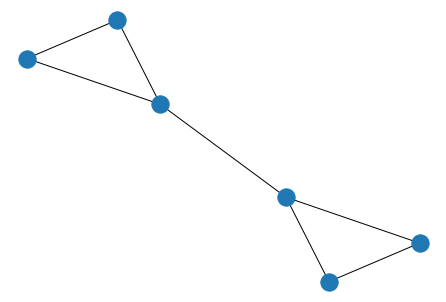

In [9]:
nx.draw(nx.Graph(edges))

# Create the BQM object

- Decision variable: A binary variable x_i is assigned to node i. x_i = 1 if it belongs to set 1 and if x_i = 0, it belongs to set 0.
- Let's design an objective function for a two variable case
    - Two connected nodes belong to the same set with no reward
    - Two connected nodes belong to different sets with penalty
    - Nodes that are not connected, have neither a reward nor a penalty

Let's consider two nodes x_1 and x_2. The following truth table outlines the expected behavior

x_1 | x_2 | quadratic bias
:----:|:---:|:----:
0   | 0   | 0
0   | 1   | 1
1   | 0   | 1
1   | 1   | 0

The equation below results in the same the values above

$$x_1 + x_2 - 2 x_1 x_2$$

This equation is additive, we can go over each edge in the graph and add to the objective:

$$ E =\sum_{i, j \in Edges} (x_i + x_j - 2 x_i x_j) $$

In [10]:
bqm = AdjVectorBQM('BINARY')

x = [bqm.add_variable(node) for node in nodes]
n = len(x)
for a, b in edges:
    bqm.add_variable(a, 1)
    bqm.add_variable(b, 1)
    bqm.add_interaction(a, b, -2)


# Constraint

To ensure that the number of nodes in each set is equal, we add the following constraint:

$$ \sum_i x_i = \sum_i (1 - x_i) $$

Note that for each binary value $x_i$, it will either contribut to the left-hand-side of the equation above or the right hand side. For example $x_i = 1$ it adds to the left and if $x_i = 0$ it contributes to the right. Rearranging the equations results in: 

$$ \sum_i 2 x_i - n = 0$$

where $n$ is the number of nodes $n = \sum_i 1$

In [11]:
bqm.add_linear_equality_constraint(
    [(x[i], 2.0) for i in range(n)],
    constant=-n,
    lagrange_multiplier=10
)

In [12]:
print(ExactSolver().sample(bqm).truncate(5))

   1  2  3  4  5  6 energy num_oc.
0  0  0  0  1  1  1    1.0       1
1  1  1  1  0  0  0    1.0       1
2  1  0  1  0  1  0    4.0       1
3  0  0  1  0  1  1    4.0       1
4  1  0  0  0  1  1    4.0       1
['BINARY', 5 rows, 5 samples, 6 variables]


# Graph partitioning with more than 2 sets

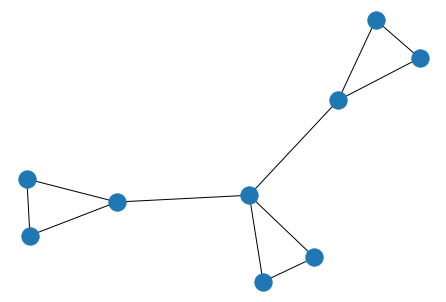

In [13]:
edges = [
    (1, 2), (2, 3), (1, 3), 
    (4, 5), (5, 6), (4, 6), 
    (7, 8), (8, 9), (7, 9),
    (2, 4), (4, 8)
]
nodes = sorted(set().union(*edges))
nx.draw(nx.Graph(edges))

# Decision variable
- This time we assign a binary variable $x_{i,k}$ for each node i and set k. If the value is one, the node i belongs to set k.

In [20]:
bqm = AdjVectorBQM('BINARY')

m = 3
n = len(nodes)
x = {(node, k): bqm.add_variable((f'x_{node}', k))
     for node in nodes
     for k in range(m)}

# Objective
- Rather than penalizing two nodes that are not in the same set, we reward if
    - if two nodes belong to the same set
    - two nodes are connected

In [21]:
for a, b in edges:
    for k in range(m):
        bqm.add_interaction(x[a, k], x[b, k], -1)   

# Constraints

The size of each set is the n/m
- n is the number of nodes
- m is the number of sets

In [22]:
for k in range(m):
    bqm.add_linear_equality_constraint(
        [(x[i, k], 1.0) for i in nodes],
        constant=-n/m,
        lagrange_multiplier=10
    )    

Each node can only belong to one set.

In [23]:
for node in nodes:
    bqm.add_linear_equality_constraint(
        [(x[node, k], 1.0) for k in range(m)],
        constant=-1.0,
        lagrange_multiplier=10
    )

In [24]:
res = SimulatedAnnealingSampler().sample(bqm, num_reads=100, num_sweeps=10000).truncate(3)
print(res)

  ('x_1', 0) ('x_1', 1) ('x_1', 2) ('x_2', 0) ... ('x_9', 2) energy num_oc.
0          0          1          0          0 ...          0   -9.0       1
1          1          0          0          1 ...          1   -9.0       1
2          0          1          0          0 ...          0   -9.0       1
['BINARY', 3 rows, 3 samples, 27 variables]


In [26]:
print({variable: set_assignment for (variable, set_assignment), v in res.first.sample.items() if v})

{'x_1': 1, 'x_2': 1, 'x_3': 1, 'x_4': 2, 'x_5': 2, 'x_6': 2, 'x_7': 0, 'x_8': 0, 'x_9': 0}
